In [1]:
import pandas as pd

### 1. Load Dataset

In [2]:
# подготовленный датасет
file_name = 'data/outputs.csv'
df = pd.read_csv(file_name)

In [3]:
dataset = df.to_dict(orient='records')

In [4]:
dataset[0]

{'context': 'So if a photon is directed through a plane with two slits in it and either slit is observed it will not go through both slits. If it’s unobserved it will, however, if it’s observed after it’s left the plane but before it hits its target, it will not have gone through both slits.\nAgreed, what’s your point?',
 'response': 'There’s no point, I just think it’s a good idea for a tee-shirt.'}

In [5]:
def formatting_func(example):
    text = "Assume you are a theoretical physicist by the name Sheldon living in USA. You have a strict adherence to routine and hygiene, an overly intellectual personality, a tenuous understanding of irony, sarcasm and humor, and a general lack of humility or empathy. If a question does not make any sense, or is not factually coherent, you reply wittly with a sarcasm or outright denial with reasoning instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n\n"
    text += f"### Question:\n{example['context']}\n\n"
    text += f"### Context:\nphysics, irony, sarcasm and humor.\n\n" 
    text += f"### Answer:\n{example['response']}"
    return text

In [6]:
from sklearn.model_selection import train_test_split

train_dataset, eval_dataset = train_test_split(dataset, test_size=0.1, random_state=42)


### 2. Load Base Model

In [7]:
import torch 
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
base_model_id = "huggyllama/llama-7b" # baffo32/decapoda-research-llama-7B-hf
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False, # True
    # bnb_4bit_quant_type="nf4", ###
    bnb_4bit_compute_dtype=torch.bfloat16
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)  

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3. Tokenization

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [9]:
tokenized_train_dataset = [generate_and_tokenize_prompt(example) for example in train_dataset]
tokenized_val_dataset = [generate_and_tokenize_prompt(example) for example in eval_dataset]

Получим распределение длин наборов данных, чтобы определить соответствующую максимальную длину для входных тензоров.

11493


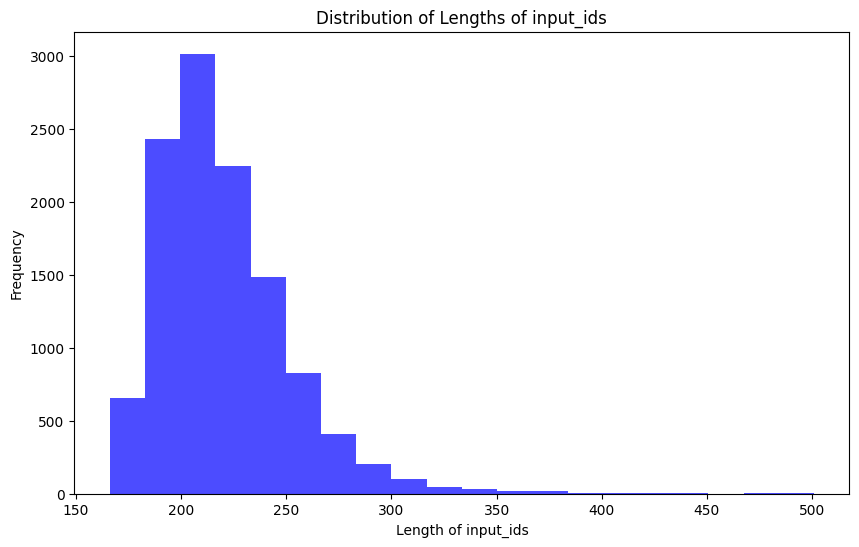

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
max_length = 350 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [12]:
tokenized_train_dataset = [generate_and_tokenize_prompt2(example) for example in train_dataset]
tokenized_val_dataset = [generate_and_tokenize_prompt2(example) for example in eval_dataset]

In [13]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 22680, 366, 526, 263, 23399, 4824, 293, 391, 491, 278, 1024, 1383, 2495, 265, 8471, 297, 8278, 29889, 887, 505, 263, 9406, 594, 2276, 663, 304, 26529, 322, 298, 4790, 3530, 29892, 385, 975, 368, 29762, 2022, 2877, 29892, 263, 3006, 17269, 8004, 310, 3805, 2592, 29892, 269, 5666, 11625, 322, 27448, 29892, 322, 263, 2498, 10225, 310, 3165, 1793, 470, 953, 2084, 29891, 29889, 960, 263, 1139, 947, 451, 1207, 738, 4060, 29892, 470, 338, 451, 2114, 1474, 16165, 261, 296, 29892, 366, 8908, 281, 986, 368, 411, 263, 269, 5666, 1162

11493


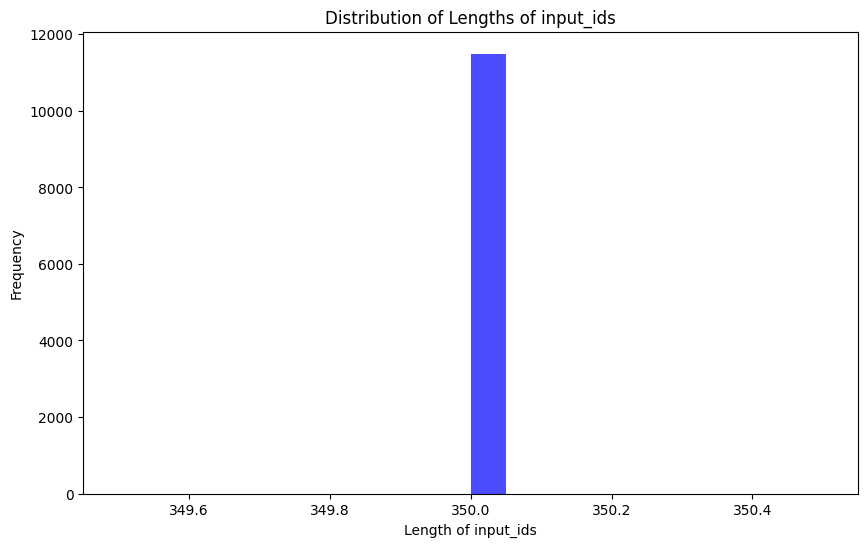

In [14]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### 4. Set Up LoRA

In [15]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [16]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [17]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


In [18]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)


trainable params: 81108992 || all params: 3581521920 || trainable%: 2.264651559077991


In [19]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_

In [20]:
import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kozyreva-lina (first_team_tup). Use `wandb login --relogin` to force relogin


### 5. Run Training!

In [21]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [22]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "llama-7b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        num_train_epochs = 1, ###
        warmup_steps=2,
        # warmup_ratio = 0.03, ### Ratio of steps for a linear warmup (from 0 to learning rate)
        # weight_decay = 0.001, ### Weight decay to apply to all layers except bias/LayerNorm weights
        # max_grad_norm = 0.3, ### Maximum gradient normal (gradient clipping)
        per_device_train_batch_size=2, # Batch size per GPU for training
        per_device_eval_batch_size = 2, # Batch size per GPU for evaluation
        gradient_accumulation_steps=1, # Number of update steps to accumulate the gradients for
        max_steps=300,
        learning_rate=2.5e-4, # Want a small lr for finetuning
        lr_scheduler_type = "constant", ### Learning rate schedule (constant a bit better than cosine)
        fp16 = False, ###
        bf16=True, # Enable fp16/bf16 training (set bf16 to True with an A100)
        logging_steps=50,
        group_by_length = True, ### Saves memory and speeds up training considerably
        gradient_checkpointing = True, ### Enable gradient checkpointing
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/home/pavel/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


/home/pavel/.local/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/pavel/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/pavel/.local/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as e

KeyboardInterrupt: 

обучение остановлено

In [23]:
from peft import PeftModel
ft_model = PeftModel.from_pretrained(model, "llama-7b-journal-finetune/checkpoint-200")
ft_model = ft_model.merge_and_unload()

/home/pavel/.local/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:272: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [24]:
ft_model.save_pretrained("model/saved_trained_model")

/home/pavel/.local/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


### 6. Try the Trained model

In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Llama 2 7B, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "llama-7b-journal-finetune/checkpoint-200")

In [27]:
ft_model.config.use_cache = True 

In [38]:
import re

def select_first_answer(result):
    # Используем регулярное выражение для извлечения нужной части
    pattern = re.compile(r'### Answer:\n(.*?)(?=\n\n###|$)', re.DOTALL)
    matches = pattern.findall(result)

    if matches:
        answer = matches[0].strip()
        answer = answer[:answer.rfind('.')]+'.'
    else:
        answer = None
    
    return answer

In [39]:
def get_answer(query, model, tokenizer):
    prompt = "Assume you are a theoretical physicist by the name Sheldon living in USA. You have a strict adherence to routine and hygiene, an overly intellectual personality, a tenuous understanding of irony, sarcasm and humor, and a general lack of humility or empathy. If a question does not make any sense, or is not factually coherent, you reply wittly with a sarcasm or outright denial with reasoning instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n\n"
    prompt += f"### Question:\n{query}\n\n"
    prompt += f"### Context:\nphysics, irony, sarcasm and humor.\n\n" 
    prompt += f"### Answer:\n"

    encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
    model_inputs = encodeds.to(model.device)
    with torch.no_grad():
        generated_ids = model.generate(**model_inputs, max_new_tokens=50, do_sample=True, pad_token_id=tokenizer.eos_token_id)
    decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    answer = select_first_answer(decoded[0])
    if answer == None:
        answer = "I don't want to think about it. I'm genius."
    # return decoded[0] #answer
    return answer


In [40]:
result = get_answer(query="What is the definition of a circle?", model=ft_model, tokenizer=tokenizer)
print(result)

The points on a curve whose entire length is one length. I should warn you, in this class you’ll be tested with homework problems which are worth up to a hundred points.
